In [242]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
%matplotlib inline

# The images are in the safari/training folder
data_path = r"C:\Machine_Learning\MLG382_Project\safari\training-medium"

In [243]:
#%pip install tensorflow-directml-plugin

In [244]:
import tensorflow as tf

print(tf.config.list_physical_devices(
    device_type=None
))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [245]:
# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

10 classes:
['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elefante', 'horse', 'sheep', 'spider', 'squirrel']


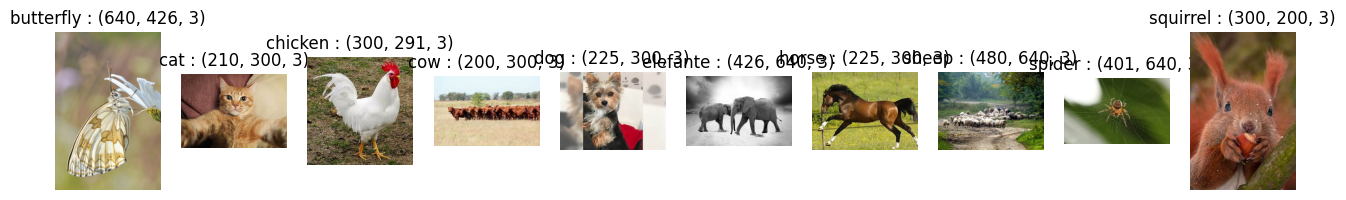

In [246]:
# Show the first image in each folder
fig = plt.figure(figsize=(16, 20))#sets the size of the figure to 12x12 inches using the figsize parameter
i = 0
for sub_dir in os.listdir(data_path): #starts a loop that iterates over each item (subdirectory) in the list of directories within the data_path directory,
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path) #The image data is stored in the variable img
    img_shape = np.array(img).shape 
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(sub_dir + ' : ' + str(img_shape))

plt.show()

cat


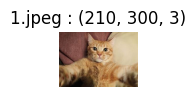

In [247]:
fig = plt.figure(figsize=(12, 12))#sets the size of the figure to 12x12 inches using the figsize parameter

# with specific name in the class
target_class = 'cat'
i = 0
for sub_dir in os.listdir(data_path):
    if sub_dir == target_class:
        i += 1
        img_file = os.listdir(os.path.join(data_path, sub_dir))[0]
        img_path = os.path.join(data_path, sub_dir, img_file)
        img = mpimg.imread(img_path)
        img_shape = img.shape
        a = fig.add_subplot(1, len(classes), i)
        a.axis('off')
        imgplot = plt.imshow(img)
        a.set_title(img_file + ' : ' + str(img_shape))
        print(sub_dir)
plt.show()

In [248]:
import tensorflow.keras
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

# Define a CNN classifier network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Flatten, Dense, MaxPool2D, BatchNormalization, experimental
import os
import cv2
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import concurrent.futures

In [249]:
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Get the class names
classes = os.listdir(data_path)
classes.sort()
num_classes = len(classes)
print(num_classes, 'classes:')
print(classes)

# Define image size
img_size = (256, 256)

# Define a function to load and preprocess an image
def load_and_preprocess_image(img_path, class_id):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0  # scale to [0, 1]
    return img, tf.one_hot(class_id, num_classes)


# Get a list of all image paths and corresponding labels
img_paths = []
labels = []
for class_id, class_name in enumerate(classes):
    class_dir = os.path.join(data_path, class_name)
    class_img_paths = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)]
    class_labels = [class_id] * len(class_img_paths)
    img_paths += class_img_paths
    labels += class_labels



# Split the data into train and validation sets
img_paths_train, img_paths_val, labels_train, labels_val = train_test_split(img_paths, labels, test_size=0.3, stratify=labels, random_state=42)

# Convert lists to Tensors
img_paths_train = tf.constant(img_paths_train)
labels_train = tf.constant(labels_train)
img_paths_val = tf.constant(img_paths_val)
labels_val = tf.constant(labels_val)

train_ds = tf.data.Dataset.from_tensor_slices((img_paths_train, labels_train))
val_ds = tf.data.Dataset.from_tensor_slices((img_paths_val, labels_val))

# Map the load_and_preprocess_image function to the datasets
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Create a function to apply data augmentation
def apply_data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Random contrast

    return image, label


# Apply data augmentation to the training dataset
#train_ds = train_ds.map(apply_data_augmentation)

train_ds = train_ds.repeat()

# Batch and prefetch the datasets
batch_size = 50

train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


10 classes:
['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elefante', 'horse', 'sheep', 'spider', 'squirrel']


In [250]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.00001), input_shape=(*img_size, 3), padding='same'),
    BatchNormalization(), 
    MaxPooling2D(),
        
    # Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same'),
    # BatchNormalization(), 
    # MaxPooling2D(),
    # Dropout(0.5),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.00001), padding='same'),
    BatchNormalization(), 
    MaxPooling2D(),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.00001), padding='same'),
    BatchNormalization(), 
    MaxPooling2D(),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.00001), padding='same'),
    BatchNormalization(), 
    MaxPooling2D(),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.00001), padding='same'),
    BatchNormalization(), 
    MaxPooling2D(),
    Dropout(0.3),
    
    Flatten(),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.00001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Get the size of train and validation datasets
dataset_size = tf.data.experimental.cardinality(train_ds).numpy()
val_dataset_size = tf.data.experimental.cardinality(val_ds).numpy()


In [251]:

# Train the model

steps_per_epoch = len(img_paths_train) // batch_size
validation_steps = len(img_paths_val) // batch_size

with tf.device('/GPU:0'):
    history = model.fit(train_ds, 
                        epochs=50, 
                        steps_per_epoch=500,                        
                        validation_data=val_ds, 
                        validation_steps=validation_steps
                        )
    

Epoch 1/50


500/500 [==============================] - 69s 136ms/step - loss: 2.0882 - accuracy: 0.2995 - val_loss: 2.4546 - val_accuracy: 0.2813
Epoch 2/50
500/500 [==============================] - 69s 138ms/step - loss: 1.7079 - accuracy: 0.4098 - val_loss: 2.3558 - val_accuracy: 0.3719
Epoch 3/50
500/500 [==============================] - 69s 138ms/step - loss: 1.4968 - accuracy: 0.4876 - val_loss: 1.3747 - val_accuracy: 0.5671
Epoch 4/50
500/500 [==============================] - 69s 138ms/step - loss: 1.3139 - accuracy: 0.5546 - val_loss: 1.3291 - val_accuracy: 0.5609
Epoch 5/50
500/500 [==============================] - 69s 138ms/step - loss: 1.2082 - accuracy: 0.5916 - val_loss: 1.6255 - val_accuracy: 0.5465
Epoch 6/50
500/500 [==============================] - 69s 138ms/step - loss: 1.1010 - accuracy: 0.6269 - val_loss: 1.1704 - val_accuracy: 0.6459
Epoch 7/50
500/500 [==============================] - 69s 139ms/step - loss: 1.0278 - accuracy: 0.6577 - val_loss: 1.0605 - val_accuracy: 0.6

In [252]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_93 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_94 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                     

157/157 [==============================] - 10s 63ms/step - loss: 1.1385 - accuracy: 0.8021
Test loss: 1.1385095119476318
Test accuracy: 0.8020660281181335


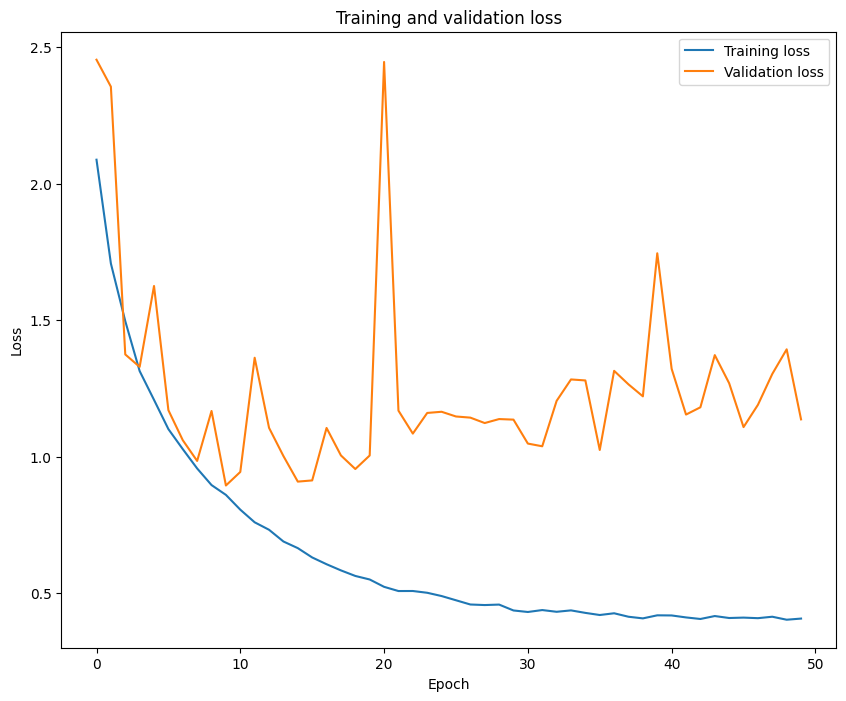

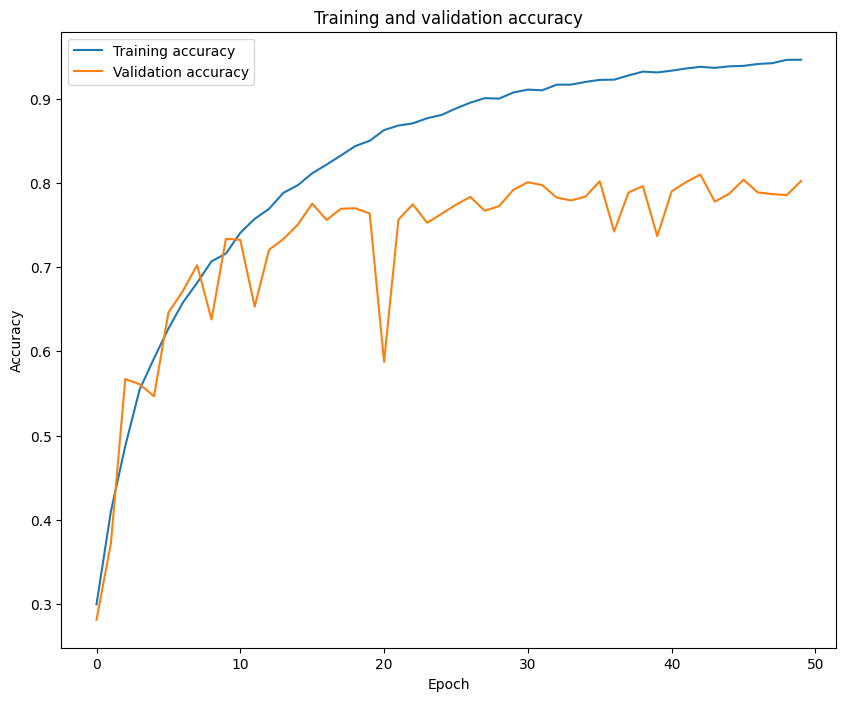

In [253]:
# Evaluate the model
score = model.evaluate(val_ds, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot the training and validation loss curves
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

157/157 [==============================] - 9s 59ms/step


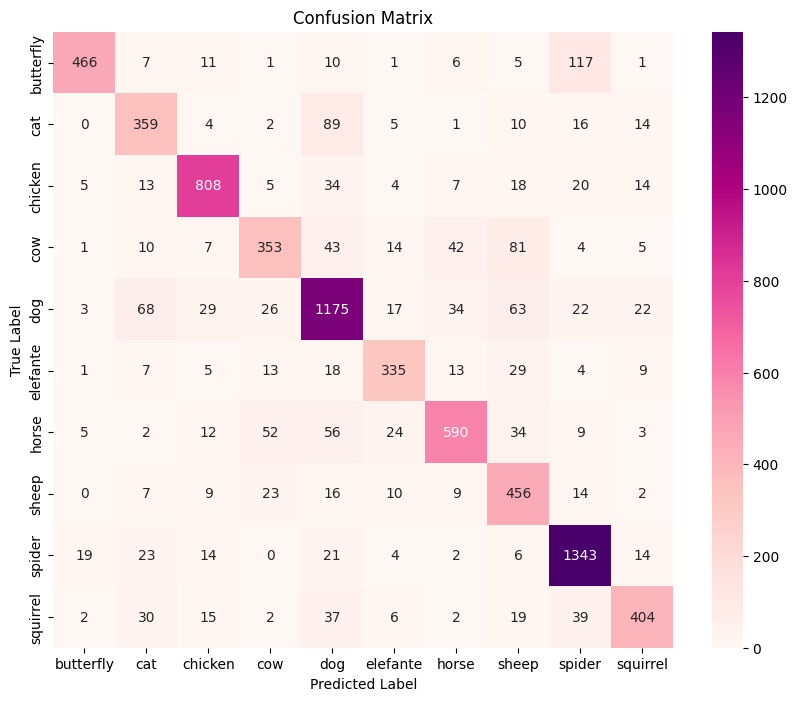

In [254]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true_classes = np.concatenate([y for x, y in val_ds], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.RdPu)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
plt.show()


In [255]:
print(cm)

[[ 466    7   11    1   10    1    6    5  117    1]
 [   0  359    4    2   89    5    1   10   16   14]
 [   5   13  808    5   34    4    7   18   20   14]
 [   1   10    7  353   43   14   42   81    4    5]
 [   3   68   29   26 1175   17   34   63   22   22]
 [   1    7    5   13   18  335   13   29    4    9]
 [   5    2   12   52   56   24  590   34    9    3]
 [   0    7    9   23   16   10    9  456   14    2]
 [  19   23   14    0   21    4    2    6 1343   14]
 [   2   30   15    2   37    6    2   19   39  404]]


In [256]:
# Save the trained model
modelFileName = 'best_model.h5'
model.save(modelFileName)
print('The model has been saved as', modelFileName)

The model has been saved as best_model.h5


1/1 [==============================] - 0s 21ms/step


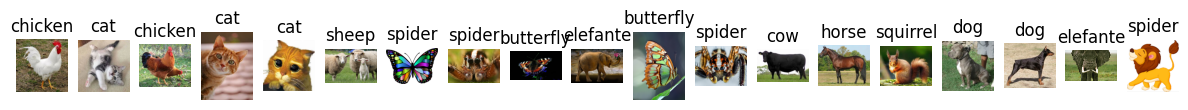

In [257]:
# Function to predict the class of an image
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    img = tensorflow.image.resize(image, [256, 256])
    # Ensure the image has 3 channels
    if img.shape[-1] == 4:
        img = img[:, :, :3]
    # Convert EagerTensor to NumPy array
    img = img.numpy()
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    imgfeatures /= 255
    
    class_probabilities = classifier.predict(imgfeatures)
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index



# Load your model
model = models.load_model(modelFileName) # loads the saved model

# The images are in the data/shapes folder
test_data_path = 'safari/test-medium'

# Show the test images with predictions
fig = plt.figure(figsize=(15, 15))
i = 0
for img_file in os.listdir(test_data_path):
    i += 1
    img_path = os.path.join(test_data_path, img_file)
    img = mpimg.imread(img_path)
    # Get the image class prediction
    index = predict_image(model, np.array(img))
    a = fig.add_subplot(1, 19, i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(classes[index])
plt.show()